# HEOM 1a: Spin-Bath model (introduction)

## Introduction

The HEOM method solves the dynamics and steady state of a system and its
environment, the latter of which is encoded in a set of auxiliary density
matrices.

In this example we show the evolution of a single two-level system in contact
with a single Bosonic environment.  The properties of the system are encoded
in a Hamiltonian, and a coupling operator which describes how it is coupled
to the environment.

The Bosonic environment is implicitly assumed to obey a particular Hamiltonian ([see paper](https://arxiv.org/abs/2010.10806)), the parameters of which are encoded in the spectral density, and subsequently the free-bath correlation functions.

In the example below we show how to model the overdamped Drude-Lorentz
Spectral Density, commonly used with the HEOM. We show how to do this using
the Matsubara, Pade and fitting decompositions, and compare their
convergence.

### Drude-Lorentz (overdamped) spectral density

The Drude-Lorentz spectral density is:

$$J_D(\omega)= \frac{2\omega\lambda\gamma}{{\gamma}^2 + \omega^2}$$

where $\lambda$ scales the coupling strength, and $\gamma$ is the cut-off
frequency.  We use the convention,
\begin{equation*}
C(t) = \int_0^{\infty} d\omega \frac{J_D(\omega)}{\pi}[\coth(\beta\omega) \
       \cos(\omega \tau) - i \sin(\omega \tau)]
\end{equation*}

With the HEOM we must use an exponential decomposition:

\begin{equation*}
C(t)=\sum_{k=0}^{k=\infty} c_k e^{-\nu_k t}
\end{equation*}

As an example, the Matsubara decomposition of the Drude-Lorentz spectral
density is given by:

\begin{equation*}
    \nu_k = \begin{cases}
               \gamma               & k = 0\\
               {2 \pi k} / {\beta }  & k \geq 1\\
           \end{cases}
\end{equation*}

\begin{equation*}
    c_k = \begin{cases}
               \lambda \gamma (\cot(\beta \gamma / 2) - i) \
               & k = 0\\
               4 \lambda \gamma \nu_k / \{(\nu_k^2 - \gamma^2)\beta \} \
               & k \geq 1\\
           \end{cases}
\end{equation*}

Note that in the above, and the following, we set $\hbar = k_\mathrm{B} = 1$.

## Setup

In [1]:
import contextlib
import time

import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt

from qutip import (
    about, basis, brmesolve, destroy, expect, liouvillian,
    qeye, sigmax, sigmaz, spost, spre, tensor
)
from qutip.core.environment import (
    DrudeLorentzEnvironment, ExponentialBosonicEnvironment, system_terminator
)
from qutip.solver.heom import HEOMSolver, HSolverDL

%matplotlib inline

## Helper functions

Let's define some helper functions for calculating correlation function expansions, plotting results and timing how long operations take:

In [2]:
def cot(x):
    """Vectorized cotangent of x."""
    return 1.0 / np.tan(x)

In [3]:
def dl_matsubara_params(lam, gamma, T, nk):
    """Calculation of the real and imaginary expansions of the Drude-Lorenz
    correlation functions.
    """
    ckAR = [lam * gamma * cot(gamma / (2 * T))]
    ckAR.extend(
        8 * lam * gamma * T * np.pi * k * T / (
            (2 * np.pi * k * T) ** 2 - gamma**2
        )
        for k in range(1, nk + 1)
    )
    vkAR = [gamma]
    vkAR.extend(2 * np.pi * k * T for k in range(1, nk + 1))

    ckAI = [lam * gamma * (-1.0)]
    vkAI = [gamma]

    return ckAR, vkAR, ckAI, vkAI

In [4]:
def plot_result_expectations(plots, axes=None):
    """Plot the expectation values of operators as functions of time.

    Each plot in plots consists of (solver_result, measurement_operation,
    color, label).
    """
    if axes is None:
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
        fig_created = True
    else:
        fig = None
        fig_created = False

    # add kw arguments to each plot if missing
    plots = [p if len(p) == 5 else p + ({},) for p in plots]
    for result, m_op, color, label, kw in plots:
        exp = np.real(expect(result.states, m_op))
        kw.setdefault("linewidth", 2)
        axes.plot(result.times, exp, color, label=label, **kw)

    if fig_created:
        axes.legend(loc=0, fontsize=12)
        axes.set_xlabel("t", fontsize=28)

    return fig

In [5]:
@contextlib.contextmanager
def timer(label):
    """Simple utility for timing functions:

    with timer("name"):
        ... code to time ...
    """
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start}")

In [6]:
# Default solver options:

default_options = {
    "nsteps": 1500,
    "store_states": True,
    "rtol": 1e-12,
    "atol": 1e-12,
    "method": "vern9",
    "progress_bar": "enhanced",
}

## System and bath definition

And let us set up the system Hamiltonian, bath and system measurement operators:

In [7]:
# Defining the system Hamiltonian
eps = 0.5  # Energy of the 2-level system.
Del = 1.0  # Tunnelling term
Hsys = 0.5 * eps * sigmaz() + 0.5 * Del * sigmax()

In [8]:
# Initial state of the system.
rho0 = basis(2, 0) * basis(2, 0).dag()

In [9]:
# System-bath coupling (Drude-Lorentz spectral density)
Q = sigmaz()  # coupling operator

# Bath properties:
gamma = 0.5  # cut off frequency
lam = 0.1  # coupling strength
T = 0.5
beta = 1.0 / T

# HEOM parameters
NC = 5  # cut off parameter for the bath
Nk = 2  # terms in the Matsubara expansion of the correlation function

# Times to solve for
tlist = np.linspace(0, 50, 1000)

In [10]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p = basis(2, 0) * basis(2, 0).dag()
P22p = basis(2, 1) * basis(2, 1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p = basis(2, 0) * basis(2, 1).dag()

### First of all, it is useful to look at the spectral density

Now we are ready to begin. Let's look at the shape of the spectral density given the bath parameters we defined above:

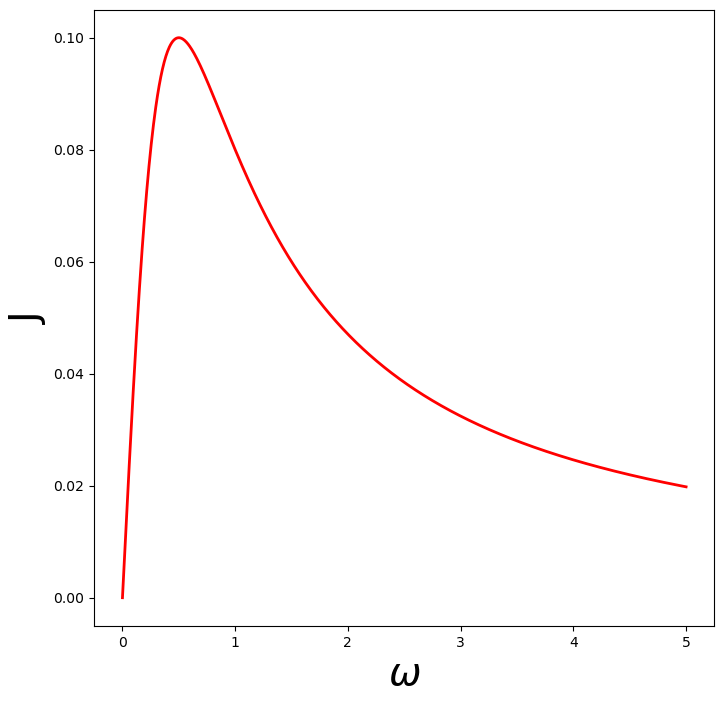

In [11]:
def plot_spectral_density():
    """Plot the Drude-Lorentz spectral density"""
    w = np.linspace(0, 5, 1000)
    J = w * 2 * lam * gamma / (gamma**2 + w**2)

    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
    axes.plot(w, J, "r", linewidth=2)
    axes.set_xlabel(r"$\omega$", fontsize=28)
    axes.set_ylabel(r"J", fontsize=28)


plot_spectral_density()

Next we calculate the exponents using the Matsubara decompositions. Here we
split them into real and imaginary parts.

The HEOM code will optimize these, and reduce the number of exponents when
real and imaginary parts have the same exponent. This is clearly the case
for the first term in the vkAI and vkAR lists.

In [12]:
ckAR, vkAR, ckAI, vkAI = dl_matsubara_params(nk=Nk, lam=lam, gamma=gamma, T=T)

Having created the lists which specify the bath correlation functions, we
create an `ExponentialBosonicEnvironment` from them and pass the environment to the `HEOMSolver` class.

The solver constructs the "right hand side" (RHS) determinining how the
system and auxiliary density operators evolve in time. This can then be used
to solve for dynamics or steady-state.

Below we create the bath and solver and then solve for the dynamics by
calling `.run(rho0, tlist)`.

In [13]:
options = {**default_options}

with timer("RHS construction time"):
    env = ExponentialBosonicEnvironment(ckAR, vkAR, ckAI, vkAI)
    HEOMMats = HEOMSolver(Hsys, (env, Q), NC, options=options)

with timer("ODE solver time"):
    resultMats = HEOMMats.run(rho0, tlist)

RHS construction time: 0.019286632537841797
 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.55s / Remaining 00:00:00:00

 Total run time:   0.55s
ODE solver time: 0.5537548065185547


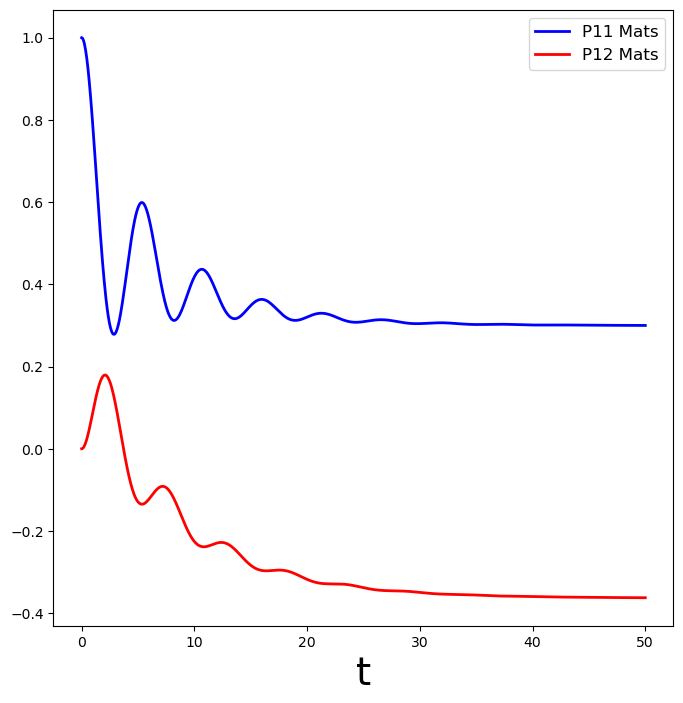

In [14]:
plot_result_expectations(
    [
        (resultMats, P11p, "b", "P11 Mats"),
        (resultMats, P12p, "r", "P12 Mats"),
    ]
);

In practice, one would not perform this laborious expansion for the
Drude-Lorentz correlation function, because QuTiP already has a class,
`DrudeLorentzEnvironment`, that can construct this bath for you. Nevertheless,
knowing how to perform this expansion will allow you to construct your own
baths for other spectral densities.

Below we show how to use this built-in functionality:

In [15]:
# Compare to built-in Drude-Lorentz bath:

with timer("RHS construction time"):
    # Abstract representation of D-L Environment
    dlenv = DrudeLorentzEnvironment(lam=lam, gamma=gamma, T=T)
    # Matsubara approximation of D-L Environment
    dlenv_approx = dlenv.approximate(method="matsubara", Nk=Nk)
    HEOM_dlbath = HEOMSolver(Hsys, (dlenv_approx, Q), NC, options=options)

with timer("ODE solver time"):
    result_dlbath = HEOM_dlbath.run(rho0, tlist)

RHS construction time: 0.019331932067871094


 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.53s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.55s / Remaining 00:00:00:00

 Total run time:   0.55s
ODE solver time: 0.5492024421691895


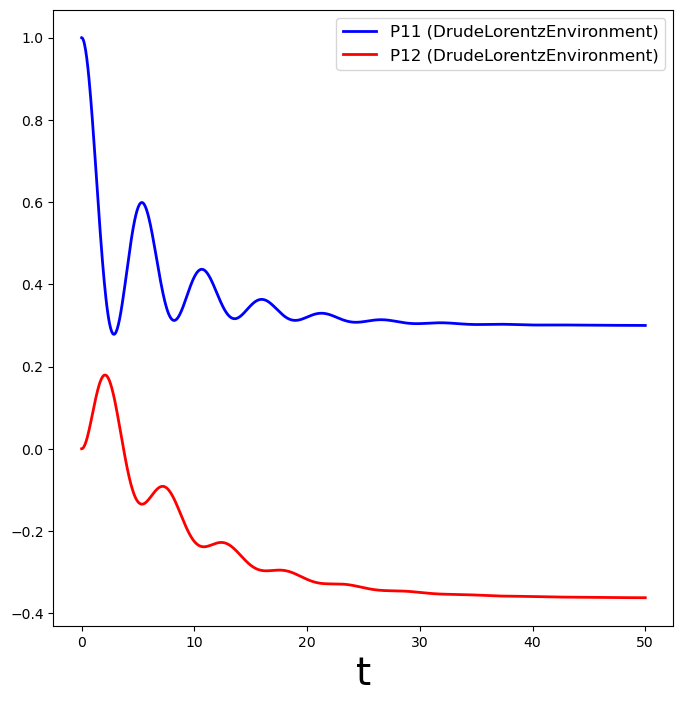

In [16]:
plot_result_expectations(
    [
        (result_dlbath, P11p, "b", "P11 (DrudeLorentzEnvironment)"),
        (result_dlbath, P12p, "r", "P12 (DrudeLorentzEnvironment)"),
    ]
);

The `DrudeLorentzEnvironment` class also allows us to easily obtain the power spectrum, correlation function, and spectral density. The approximated Environment is a `BosonicEnvironment` where the approximated correlation function, and the corresponding effective power spectrum and spectral density are also accessible. In the following plots, the solid lines are the exact expressions, and the dashed lines are based on our Matsubara approximation of the correlation function with a finite number of exponents.

The `DrudeLorentzEnvironment` computes the exact correlation function using the Pade approximation. The number of terms to use defaults to $10$, but when simulating low temperatures, $10$ Pade exponents may noy be enough. More details about the Pade approximation are provided below. Next we show how to use this built-in functionality:

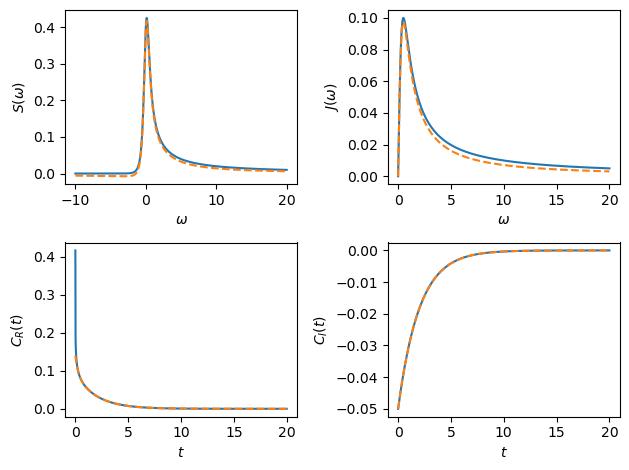

In [17]:
w = np.linspace(-10, 20, 1000)
w2 = np.linspace(0, 20, 1000)

fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(w, dlenv.power_spectrum(w))
axs[0, 0].plot(w, dlenv_approx.power_spectrum(w), "--")
axs[0, 0].set(xlabel=r"$\omega$", ylabel=r"$S(\omega)$")
axs[0, 1].plot(w2, dlenv.spectral_density(w2))
axs[0, 1].plot(w2, dlenv_approx.spectral_density(w2), "--")
axs[0, 1].set(xlabel=r"$\omega$", ylabel=r"$J(\omega)$")
axs[1, 0].plot(w2, np.real(dlenv.correlation_function(w2, Nk=100)))  # 100 Pade
axs[1, 0].plot(w2, np.real(dlenv_approx.correlation_function(w2)), "--")
axs[1, 0].set(xlabel=r"$t$", ylabel=r"$C_{R}(t)$")
axs[1, 1].plot(w2, np.imag(dlenv.correlation_function(w2, Nk=100)))
axs[1, 1].plot(w2, np.imag(dlenv_approx.correlation_function(w2)), "--")
axs[1, 1].set(xlabel=r"$t$", ylabel=r"$C_{I}(t)$")

fig.tight_layout()
plt.show()

We also provide a legacy class, `HSolverDL`, which calculates the
Drude-Lorentz correlation functions automatically, to be backwards
compatible with the previous HEOM solver in QuTiP:

In [18]:
# Compare to legacy class:

# The legacy class performs the above collation of coefficients automatically,
# based upon the parameters for the Drude-Lorentz spectral density.

with timer("RHS construction time"):
    HEOMlegacy = HSolverDL(Hsys, Q, lam, T, NC, Nk, gamma, options=options)

with timer("ODE solver time"):
    resultLegacy = HEOMlegacy.run(rho0, tlist)  # normal  115

RHS construction time: 0.018490314483642578
 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.37s / Remaining 00:00:00:00

[*********77%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.47s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.47s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.48s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.49s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.49s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.49s / Remaining 00:00:00:00

 Total run time:   0.49s
ODE solver time: 0.48682332038879395


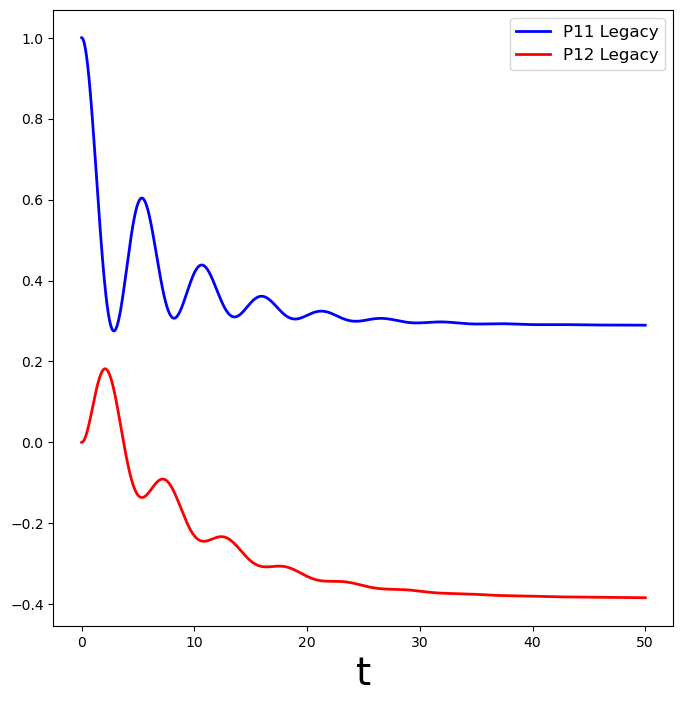

In [19]:
plot_result_expectations(
    [
        (resultLegacy, P11p, "b", "P11 Legacy"),
        (resultLegacy, P12p, "r", "P12 Legacy"),
    ]
);

Another legacy class kept for convenience is the `DrudeLorentzBath`. The code
```python
dlenv = DrudeLorentzEnvironment(lam=lam, gamma=gamma, T=T)
dlenv_approx = dlenv.approximate(method="matsubara", Nk=Nk)  # Computes Matsubara exponents
HEOM_dlbath = HEOMSolver(Hsys, (dlenv_approx, Q), NC, options=options)
```
that we used above is equivalent to the following code:
```python
dlbath = DrudeLorentzBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)
HEOM_dlbath = HEOMSolver(Hsys, dlbath, NC, options=options)
```

## Ishizaki-Tanimura Terminator

To speed up convergence (in terms of the number of exponents kept in the
Matsubara decomposition), We can treat the $Re[C(t=0)]$ component as a
delta-function distribution, and include it as Lindblad correction. This is
sometimes known as the Ishizaki-Tanimura Terminator.

In more detail, given

\begin{equation*}
C(t)=\sum_{k=0}^{\infty} c_k e^{-\nu_k t}
\end{equation*}

since $\nu_k=\frac{2 \pi k}{\beta }$, if $1/\nu_k$ is much much smaller than
other important time-scales, we can approximate,
$ e^{-\nu_k t} \approx \delta(t)/\nu_k$, and $C(t)=\sum_{k=N_k}^{\infty}
\frac{c_k}{\nu_k} \delta(t)$

It is convenient to calculate the whole sum
$ C(t)=\sum_{k=0}^{\infty} \frac{c_k}{\nu_k} =  2 \lambda / (\beta \gamma)- i\lambda $
, and subtract off the contribution from the finite number of Matsubara terms
that are kept in the hierarchy, and treat the residual as a contribution in 
Lindblad form.

This is clearer if we plot the correlation function with a large number of
Matsubara terms. To create the plot, we use the utility function of the
`DrudeLorentzEnvironment` class mentioned above.

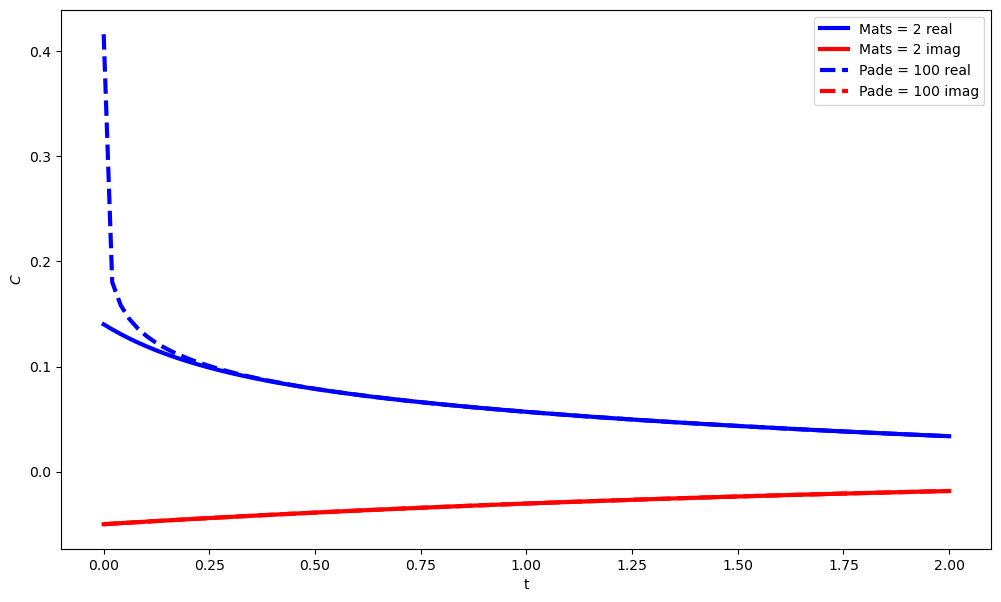

In [20]:
def plot_correlation_expansion_divergence():
    """We plot the correlation function with a large number of Matsubara terms
    to show that the real part is slowly diverging at t = 0.
    """
    t = np.linspace(0, 2, 100)

    # correlation coefficients with 100 pade and with 2 matsubara terms
    corr_100 = dlenv.correlation_function(t, Nk=100)
    corr_2 = dlenv_approx.correlation_function(t)

    fig, ax1 = plt.subplots(figsize=(12, 7))

    ax1.plot(
        t, np.real(corr_2), color="b", linewidth=3, label=rf"Mats = {Nk} real"
    )
    ax1.plot(
        t, np.imag(corr_2), color="r", linewidth=3, label=rf"Mats = {Nk} imag"
    )
    ax1.plot(
        t, np.real(corr_100), "b--", linewidth=3, label=r"Pade = 100 real"
    )
    ax1.plot(
        t, np.imag(corr_100), "r--", linewidth=3, label=r"Pade = 100 imag"
    )

    ax1.set_xlabel("t")
    ax1.set_ylabel(r"$C$")
    ax1.legend()


plot_correlation_expansion_divergence()

Let us evaluate the result including this Ishizaki-Tanimura terminator:

In [21]:
# Run HEOM solver including the Ishizaki-Tanimura terminator

# Notes:
#
# * here, we will first show how to compute the terminator manually
#
# * when using the built-in DrudeLorentzEnvironment the terminator (L_bnd) is
#   available from by setting the parameter compute_delta to True in the
#   approximate method
#
# * in the legacy HSolverDL function the terminator is included automatically
#   if the parameter bnd_cut_approx=True is used.

op = -2 * spre(Q) * spost(Q.dag()) + spre(Q.dag() * Q) + spost(Q.dag() * Q)

approx_factr = (2 * lam / (beta * gamma)) - 1j * lam

approx_factr -= lam * gamma * (-1.0j + cot(gamma / (2 * T))) / gamma
for k in range(1, Nk + 1):
    vk = 2 * np.pi * k * T

    approx_factr -= (4 * lam * gamma * T * vk / (vk**2 - gamma**2)) / vk

L_bnd = -approx_factr * op

Ltot = -1.0j * (spre(Hsys) - spost(Hsys)) + L_bnd
Ltot = liouvillian(Hsys) + L_bnd

options = {**default_options, "rtol": 1e-14, "atol": 1e-14}

with timer("RHS construction time"):
    env = ExponentialBosonicEnvironment(ckAR, vkAR, ckAI, vkAI)
    HEOMMatsT = HEOMSolver(Ltot, (env, Q), NC, options=options)

with timer("ODE solver time"):
    resultMatsT = HEOMMatsT.run(rho0, tlist)

RHS construction time: 0.019118309020996094
 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.55s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.55s / Remaining 00:00:00:00

 Total run time:   0.55s
ODE solver time: 0.5502262115478516


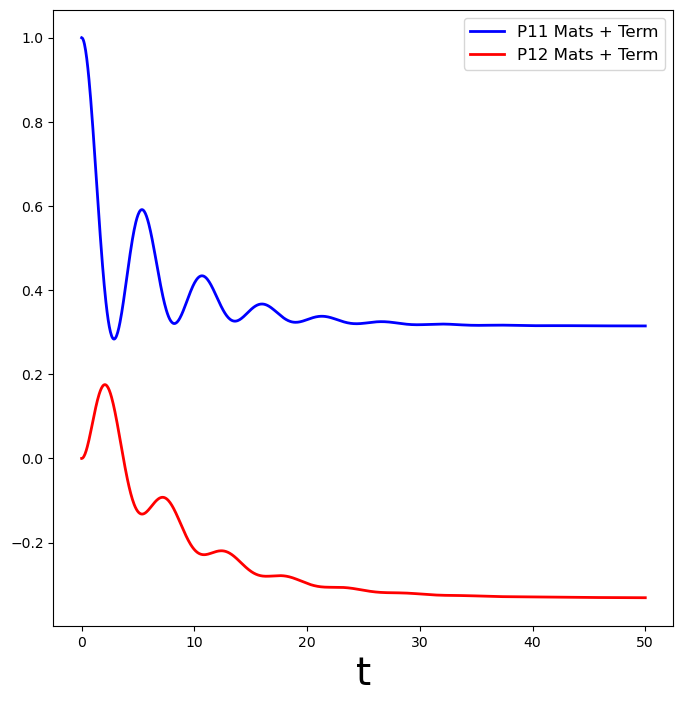

In [22]:
plot_result_expectations(
    [
        (resultMatsT, P11p, "b", "P11 Mats + Term"),
        (resultMatsT, P12p, "r", "P12 Mats + Term"),
    ]
);

Or using the built-in Drude-Lorentz environment we can write simply:

In [23]:
options = {**default_options, "rtol": 1e-14, "atol": 1e-14}

with timer("RHS construction time"):
    dlenv_approx, delta = dlenv.approximate(
        "matsubara", Nk=Nk, compute_delta=True
    )
    Ltot = liouvillian(Hsys) + system_terminator(Q, delta)
    HEOM_dlbath_T = HEOMSolver(Ltot, (dlenv_approx, Q), NC, options=options)

with timer("ODE solver time"):
    result_dlbath_T = HEOM_dlbath_T.run(rho0, tlist)

RHS construction time: 0.01978921890258789


 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.53s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.53s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.53s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.53s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.53s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.53s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.53s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.53s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.54s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.54s / Remaining 00:00:00:00

 Total run time:   0.55s
ODE solver time: 0.5452573299407959


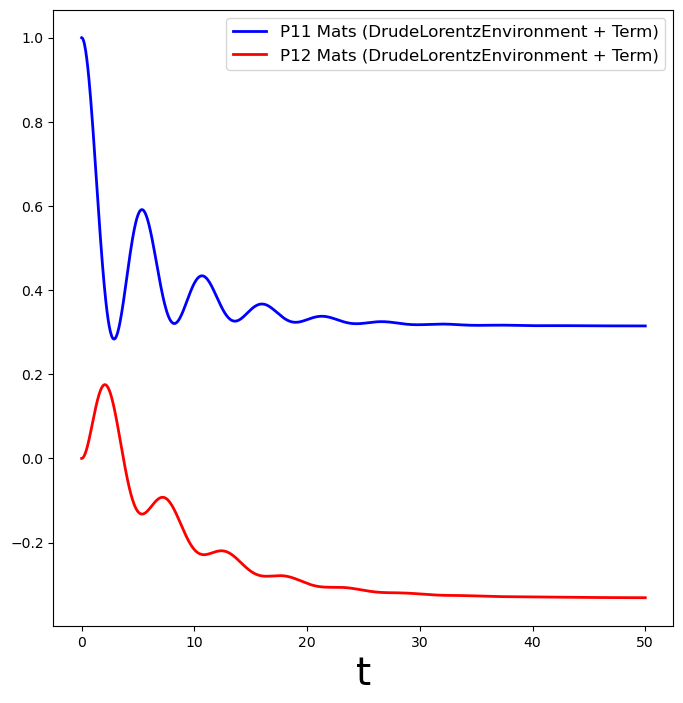

In [24]:
plot_result_expectations([
    (result_dlbath_T, P11p, "b", "P11 Mats (DrudeLorentzEnvironment + Term)"),
    (result_dlbath_T, P12p, "r", "P12 Mats (DrudeLorentzEnvironment + Term)"),
]);

We can compare the solution obtained from the QuTiP Bloch-Redfield solver:

In [25]:
options = {**default_options}

with timer("ODE solver time"):
    resultBR = brmesolve(
        Hsys, rho0, tlist, a_ops=[[sigmaz(), dlenv]], options=options
    )

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.44s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.45s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.45s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.45s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.45s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.45s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.45s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.45s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.45s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.45s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.45s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.45s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.45s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.45s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.45s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.45s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.45s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.45s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.45s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.45s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.45s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.45s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.45s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.45s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.45s / Remaining 00:00:00:00

 Total run time:   0.45s
ODE solver time: 0.4565589427947998


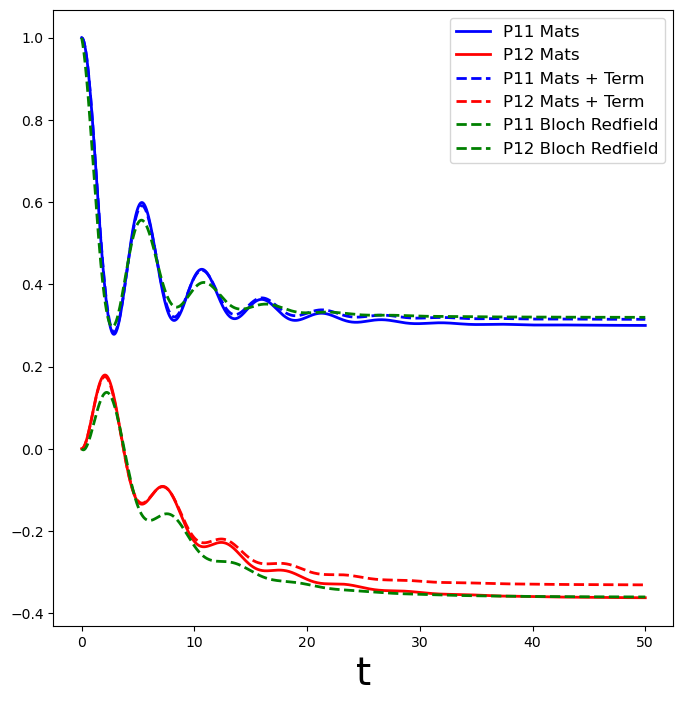

In [26]:
plot_result_expectations(
    [
        (resultMats, P11p, "b", "P11 Mats"),
        (resultMats, P12p, "r", "P12 Mats"),
        (resultMatsT, P11p, "b--", "P11 Mats + Term"),
        (resultMatsT, P12p, "r--", "P12 Mats + Term"),
        (resultBR, P11p, "g--", "P11 Bloch Redfield"),
        (resultBR, P12p, "g--", "P12 Bloch Redfield"),
    ]
);

## Padé decomposition

The Matsubara decomposition is not the only option.  We can also use the
faster-converging Pade decomposition.

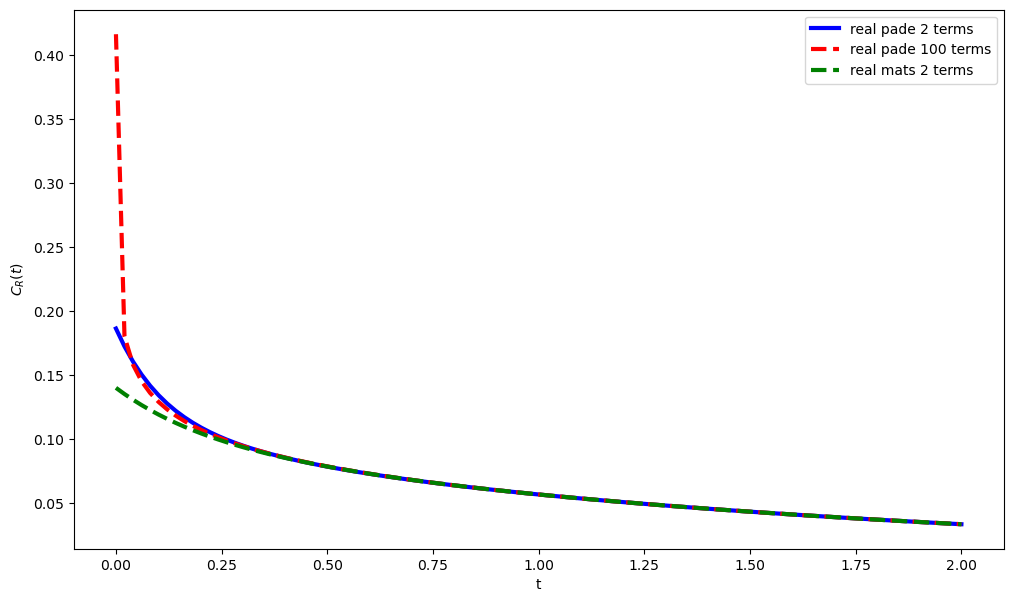

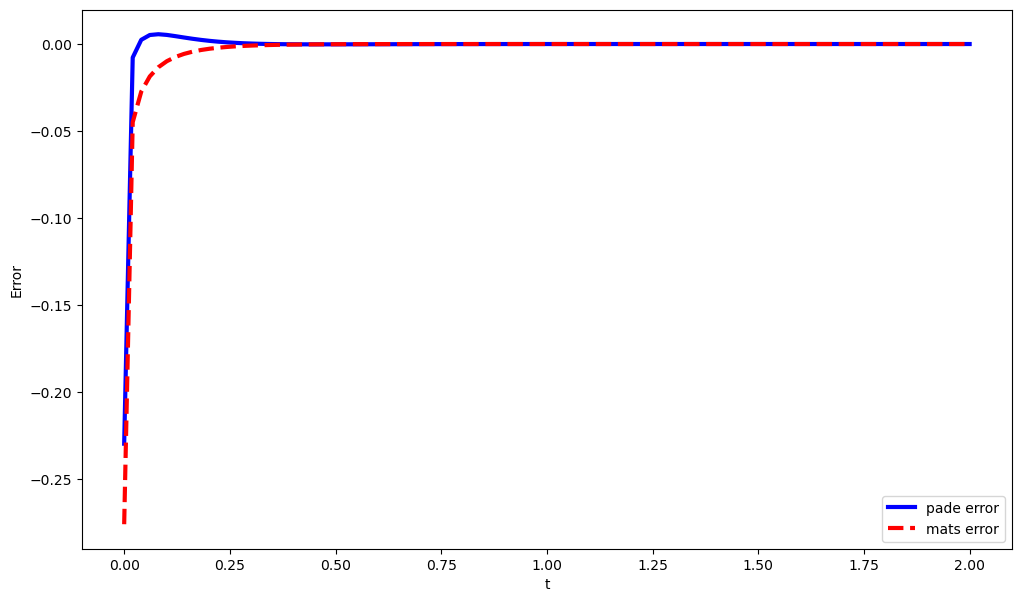

In [27]:
def deltafun(j, k):
    if j == k:
        return 1.0
    else:
        return 0.0


def pade_eps(lmax):
    Alpha = np.zeros((2 * lmax, 2 * lmax))
    for j in range(2 * lmax):
        for k in range(2 * lmax):
            # Fermionic (see other example notebooks):
            #   Alpha[j][k] = (deltafun(j, k+1) + deltafun(j, k-1))
            #                 / sqrt((2 * (j + 1) - 1) * (2 * (k + 1) - 1))
            # Bosonic:
            Alpha[j][k] = (deltafun(j, k + 1) + deltafun(j, k - 1)) / np.sqrt(
                (2 * (j + 1) + 1) * (2 * (k + 1) + 1)
            )

    eigvalsA = np.linalg.eigvalsh(Alpha)
    eps = [-2 / val for val in eigvalsA[0:lmax]]
    return eps


def pade_chi(lmax):
    AlphaP = np.zeros((2 * lmax - 1, 2 * lmax - 1))
    for j in range(2 * lmax - 1):
        for k in range(2 * lmax - 1):
            # Fermionic:
            #   AlphaP[j][k] = (deltafun(j, k + 1) + deltafun(j, k - 1))
            #                  / sqrt((2 * (j + 1) + 1) * (2 * (k + 1) + 1))
            # Bosonic [this is +3 because +1 (bose) + 2*(+1) (from bm+1)]:
            AlphaP[j][k] = (deltafun(j, k + 1) + deltafun(j, k - 1)) / np.sqrt(
                (2 * (j + 1) + 3) * (2 * (k + 1) + 3)
            )

    eigvalsAP = np.linalg.eigvalsh(AlphaP)
    chi = [-2 / val for val in eigvalsAP[0:(lmax - 1)]]
    return chi


def pade_kappa_epsilon(lmax):
    eps = pade_eps(lmax)
    chi = pade_chi(lmax)

    kappa = [0]
    prefactor = 0.5 * lmax * (2 * (lmax + 1) + 1)

    for j in range(lmax):
        term = prefactor
        for k in range(lmax - 1):
            term *= (chi[k] ** 2 - eps[j] ** 2) / (
                eps[k] ** 2 - eps[j] ** 2 + deltafun(j, k)
            )

        for k in range(lmax - 1, lmax):
            term /= eps[k] ** 2 - eps[j] ** 2 + deltafun(j, k)

        kappa.append(term)

    epsilon = [0] + eps

    return kappa, epsilon


def pade_corr(tlist, lmax):
    kappa, epsilon = pade_kappa_epsilon(lmax)

    eta_list = [lam * gamma * (cot(gamma * beta / 2.0) - 1.0j)]
    gamma_list = [gamma]

    if lmax > 0:
        for ll in range(1, lmax + 1):
            eta_list.append(
                (kappa[ll] / beta)
                * 4
                * lam
                * gamma
                * (epsilon[ll] / beta)
                / ((epsilon[ll] ** 2 / beta**2) - gamma**2)
            )
            gamma_list.append(epsilon[ll] / beta)

    c_tot = []
    for t in tlist:
        c_tot.append(
            sum(
                [
                    eta_list[ll] * np.exp(-gamma_list[ll] * t)
                    for ll in range(lmax + 1)
                ]
            )
        )
    return c_tot, eta_list, gamma_list


tlist_corr = np.linspace(0, 2, 100)
cppLP, etapLP, gampLP = pade_corr(tlist_corr, 2)
corr_100 = dlenv.correlation_function(tlist_corr, Nk=100)
corr_2 = dlenv.approximate("matsubara", Nk=2).correlation_function(tlist_corr)

fig, ax1 = plt.subplots(figsize=(12, 7))
ax1.plot(
    tlist_corr,
    np.real(cppLP),
    color="b",
    linewidth=3,
    label=r"real pade 2 terms",
)
ax1.plot(
    tlist_corr,
    np.real(corr_100),
    "r--",
    linewidth=3,
    label=r"real pade 100 terms",
)
ax1.plot(
    tlist_corr,
    np.real(corr_2),
    "g--",
    linewidth=3,
    label=r"real mats 2 terms",
)

ax1.set_xlabel("t")
ax1.set_ylabel(r"$C_{R}(t)$")
ax1.legend()

fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.plot(
    tlist_corr,
    np.real(cppLP) - np.real(corr_100),
    color="b",
    linewidth=3,
    label=r"pade error",
)
ax1.plot(
    tlist_corr,
    np.real(corr_2) - np.real(corr_100),
    "r--",
    linewidth=3,
    label=r"mats error",
)

ax1.set_xlabel("t")
ax1.set_ylabel(r"Error")
ax1.legend();

In [28]:
# put pade parameters in lists for heom solver
ckAR = [np.real(eta) + 0j for eta in etapLP]
ckAI = [np.imag(etapLP[0]) + 0j]
vkAR = [gam + 0j for gam in gampLP]
vkAI = [gampLP[0] + 0j]

options = {**default_options, "rtol": 1e-14, "atol": 1e-14}

with timer("RHS construction time"):
    bath = ExponentialBosonicEnvironment(ckAR, vkAR, ckAI, vkAI)
    HEOMPade = HEOMSolver(Hsys, (bath, Q), NC, options=options)

with timer("ODE solver time"):
    resultPade = HEOMPade.run(rho0, tlist)

RHS construction time: 0.01951146125793457
 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.58s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.58s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.58s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.58s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.58s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.58s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.58s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.58s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.58s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.59s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.59s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.59s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.59s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.59s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.59s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.59s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.59s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.59s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.59s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.59s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.59s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.59s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.59s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.59s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.59s / Remaining 00:00:00:00

 Total run time:   0.59s
ODE solver time: 0.5943615436553955


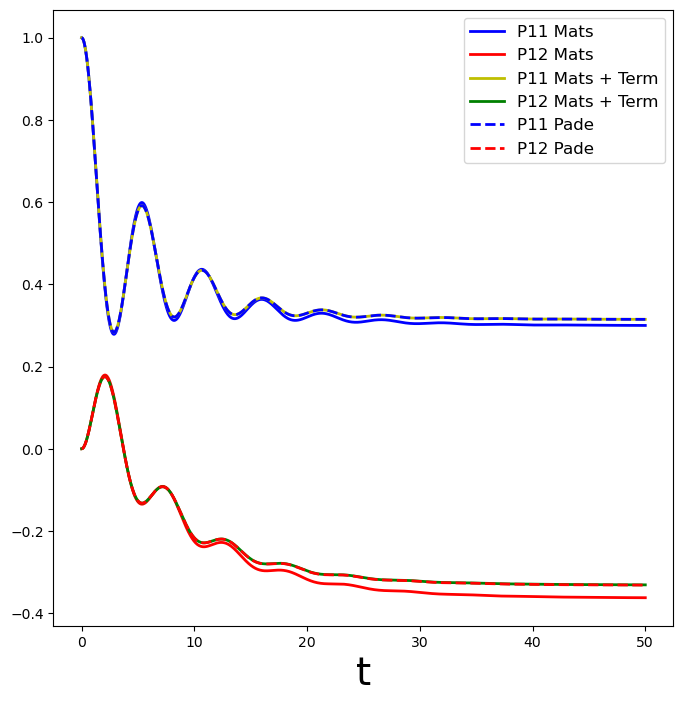

In [29]:
plot_result_expectations(
    [
        (resultMats, P11p, "b", "P11 Mats"),
        (resultMats, P12p, "r", "P12 Mats"),
        (resultMatsT, P11p, "y", "P11 Mats + Term"),
        (resultMatsT, P12p, "g", "P12 Mats + Term"),
        (resultPade, P11p, "b--", "P11 Pade"),
        (resultPade, P12p, "r--", "P12 Pade"),
    ]
);

As mentioned previously, the Padé decomposition of the Drude-Lorentz bath is also available via the
built-in `DrudeLorentzEnvironment`. Similarly to the terminator
section when approximating by Padé one can calculate the terminator easily by
requesting the approximation function to compute delta

Below we show how to use the built-in Drude-Lorentz Environment to obtain a
Padé decomposition approximation and its terminator (although the terminator 
does not provide much improvement here,because the Padé expansion already fits 
the correlation function well):

In [30]:
options = {**default_options, "rtol": 1e-14, "atol": 1e-14}

with timer("RHS construction time"):
    env_approx, delta = dlenv.approximate("pade", Nk=2, compute_delta=True)
    Ltot = liouvillian(Hsys) + system_terminator(Q, delta)
    HEOM_dlpbath_T = HEOMSolver(Ltot, (env_approx, Q), NC, options=options)

with timer("ODE solver time"):
    result_dlpbath_T = HEOM_dlpbath_T.run(rho0, tlist)

RHS construction time: 0.022244691848754883


 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.59s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.59s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.59s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.59s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.59s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.59s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.60s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.60s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.60s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.60s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.60s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.60s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.60s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.60s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.60s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.60s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.60s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.60s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.60s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.60s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.60s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.60s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.60s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.61s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.61s / Remaining 00:00:00:00

 Total run time:   0.61s
ODE solver time: 0.6071655750274658


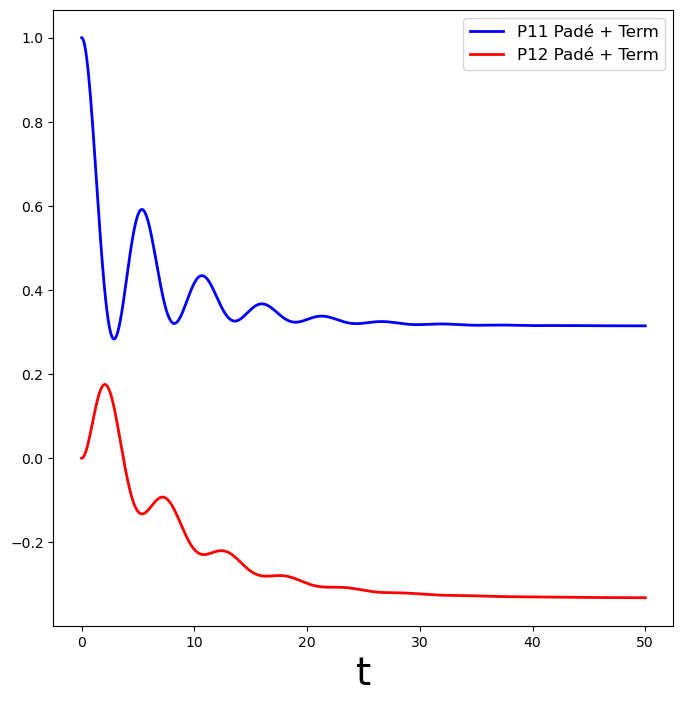

In [31]:
plot_result_expectations(
    [
        (result_dlpbath_T, P11p, "b", "P11 Padé + Term"),
        (result_dlpbath_T, P12p, "r", "P12 Padé + Term"),
    ]
);

### Next we compare the Matsubara and Pade correlation function fits

Fitting the correlation function is not efficient for this example, but
can be extremely useful in situations where large number of exponents
are needed (e.g., near zero temperature). We will perform the fitting
manually below, and then show how to do it with the built-in tools.

For the manual fit we first we collect a large sum of Pade terms for 
many time steps:

In [32]:
tlist2 = np.linspace(0, 2, 10000)

corr_100_t10k = dlenv.correlation_function(tlist2, Nk=100)
# Nk specifies the number of pade terms to be used for the correlation function

corrRana = np.real(corr_100_t10k)
corrIana = np.imag(corr_100_t10k)

corrRMats = np.real(dlenv_approx.correlation_function(tlist2))

We then fit this sum with standard least-squares approach:

In [33]:
def wrapper_fit_func(x, N, args):
    """ Fit function wrapper that unpacks its arguments. """
    x = np.array(x)
    a = np.array(args[:N])
    b = np.array(args[N:(2 * N)])
    return fit_func(x, a, b)


def fit_func(x, a, b):
    """ Fit function. Calculates the value of the
        correlation function at each x, given the
        fit parameters in a and b.
    """
    return np.sum(
        a[:, None] * np.exp(np.multiply.outer(b, x)),
        axis=0,
    )


def fitter(ans, tlist, k):
    """ Compute fit with k exponents. """
    upper_a = abs(max(ans, key=abs)) * 10
    # sets initial guesses:
    guess = (
        [upper_a / k] * k +  # guesses for a
        [0] * k  # guesses for b
    )
    # sets lower bounds:
    b_lower = (
        [-upper_a] * k +  # lower bounds for a
        [-np.inf] * k  # lower bounds for b
    )
    # sets higher bounds:
    b_higher = (
        [upper_a] * k +  # upper bounds for a
        [0] * k  # upper bounds for b
    )
    param_bounds = (b_lower, b_higher)
    p1, p2 = curve_fit(
        lambda x, *params_0: wrapper_fit_func(x, k, params_0),
        tlist,
        ans,
        p0=guess,
        sigma=[0.01 for t in tlist],
        bounds=param_bounds,
        maxfev=1e8,
    )
    a, b = p1[:k], p1[k:]
    return (a, b)

In [34]:
kR = 4  # number of exponents to use for real part
poptR = []
with timer("Correlation (real) fitting time"):
    for i in range(kR):
        poptR.append(fitter(corrRana, tlist2, i + 1))

kI = 1  # number of exponents for imaginary part
poptI = []
with timer("Correlation (imaginary) fitting time"):
    for i in range(kI):
        poptI.append(fitter(corrIana, tlist2, i + 1))

Correlation (real) fitting time: 0.5863261222839355
Correlation (imaginary) fitting time: 0.012382984161376953


And plot the results of the fits:

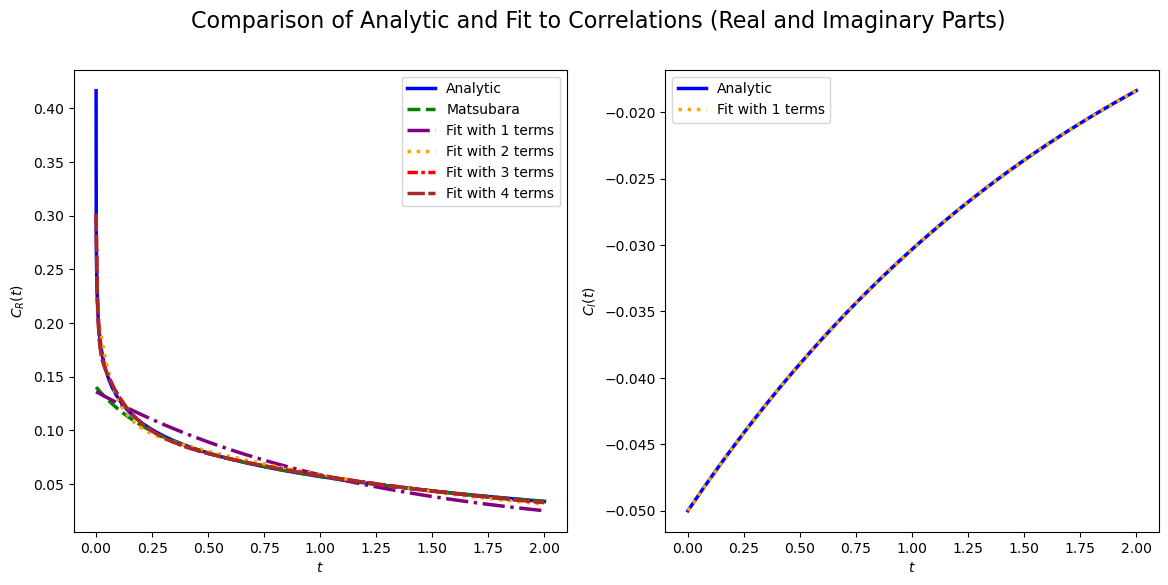

In [35]:
# Define line styles and colors
linestyles = ["-", "--", "-.", ":", (0, (3, 1, 1, 1)), (0, (5, 1))]
colors = ["blue", "green", "purple", "orange", "red", "brown"]

# Define a larger linewidth
linewidth = 2.5

# Create a single figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the real part on the first subplot (ax1)
ax1.plot(tlist2, corrRana, label="Analytic", color=colors[0],
         linestyle=linestyles[0], linewidth=linewidth)
ax1.plot(tlist2, corrRMats, label="Matsubara", color=colors[1],
         linestyle=linestyles[1], linewidth=linewidth)

for i in range(kR):
    y = fit_func(tlist2, *poptR[i])
    ax1.plot(tlist2, y, label=f"Fit with {i+1} terms", color=colors[i + 2],
             linestyle=linestyles[i + 2], linewidth=linewidth)

ax1.set_ylabel(r"$C_{R}(t)$")
ax1.set_xlabel(r"$t$")
ax1.legend()

# Plot the imaginary part on the second subplot (ax2)
ax2.plot(tlist2, corrIana, label="Analytic", color=colors[0],
         linestyle=linestyles[0], linewidth=linewidth)

for i in range(kI):
    y = fit_func(tlist2, *poptI[i])
    ax2.plot(tlist2, y, label=f"Fit with {i+1} terms", color=colors[i + 3],
             linestyle=linestyles[i + 3], linewidth=linewidth)

ax2.set_ylabel(r"$C_{I}(t)$")
ax2.set_xlabel(r"$t$")
ax2.legend()

# Add overall plot title and show the figure
fig.suptitle(
    "Comparison of Analytic and Fit to Correlations"
    " (Real and Imaginary Parts)",
    fontsize=16,
)
plt.show()

In [36]:
# Set the exponential coefficients from the fit parameters

ckAR1 = poptR[-1][0]
ckAR = [x + 0j for x in ckAR1]

vkAR1 = poptR[-1][1]
vkAR = [-x + 0j for x in vkAR1]

ckAI1 = poptI[-1][0]
ckAI = [x + 0j for x in ckAI1]

vkAI1 = poptI[-1][1]
vkAI = [-x + 0j for x in vkAI1]

In [37]:
# overwrite imaginary fit with analytical value (not much reason to use the
# fit for this)

ckAI = [lam * gamma * (-1.0) + 0.0j]
vkAI = [gamma + 0.0j]

In [38]:
options = {**default_options}

NC = 4

with timer("RHS construction time"):
    bath = ExponentialBosonicEnvironment(ckAR, vkAR, ckAI, vkAI)
    HEOMFit = HEOMSolver(Hsys, (bath, Q), NC, options=options)

with timer("ODE solver time"):
    resultFit = HEOMFit.run(rho0, tlist)

RHS construction time: 0.020078182220458984
 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.18s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.18s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.18s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.19s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.19s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.19s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.19s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.19s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.19s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.19s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.19s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.20s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.20s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.20s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.20s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.20s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.20s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.20s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.20s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.21s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.21s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.21s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.21s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.21s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.21s / Remaining 00:00:00:00

 Total run time:   1.21s
ODE solver time: 1.21211576461792


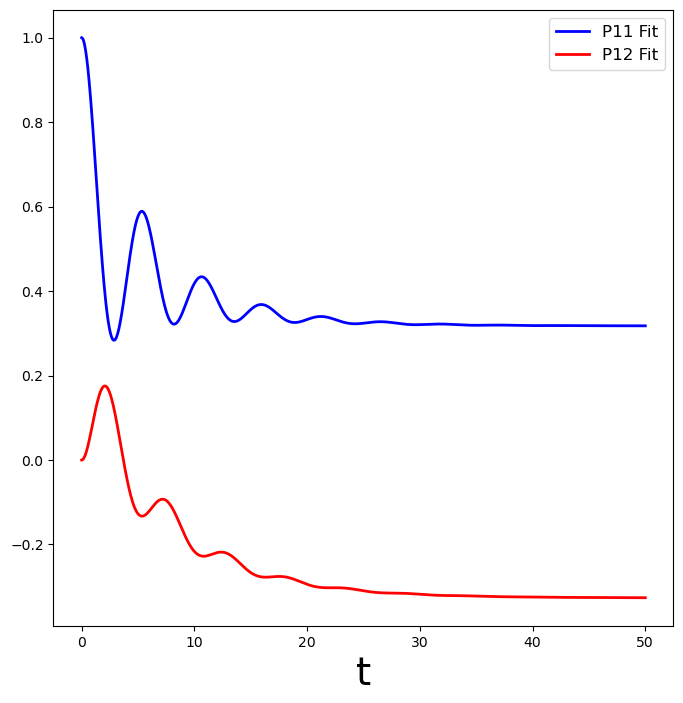

In [39]:
plot_result_expectations(
    [
        (resultFit, P11p, "b", "P11 Fit"),
        (resultFit, P12p, "r", "P12 Fit"),
    ]
);

Now we use the built-in fitting functions. The `BosonicEnvironment` class includes a 
method that performs this fit automatically. More information on how the
built-in functios work can be found in `HEOM 1d: Spin-Bath model, fitting of spectrum and correlation functions`

In [40]:
max_val = dlenv.correlation_function(0).real
guess = [max_val / 3, 0, 0, 0]
lower = [-max_val, -np.inf, -np.inf, -np.inf]
upper = [max_val, 0, 0, 0]
envfit, fitinfo = dlenv.approximate(
    "cf", tlist=tlist2, full_ansatz=True, Ni_max=1, Nr_max=3,
    upper=upper, lower=lower, guess=guess)

The `approximate("cf", ...)` method outputs an `ExponentialBosonicEnvironment` object,
which contains a decaying exponential representation of the original 
environment , and a dictionary containing all information related to the fit.
The dictionary contains a summary of the fir information and the normalized 
root mean squared error, which assesses how good the fit is.

In [41]:
print(fitinfo["summary"])

Correlation function fit:

Result of fitting the real part of                        |Result of fitting the imaginary part                       
the correlation function with 3 terms:                    |of the correlation function with 1 terms:                  
                                                          |                                                           
 Parameters|   ckr    |   vkr    |   vki    |  cki        | Parameters|   ckr    |   vkr    |   vki    |  cki         
 1         | 6.95e-02 |-6.46e+00 |-2.56e-05 |-5.12e-02    | 1         | 8.55e-02 |-5.03e-01 |-1.85e-03 |-5.00e-02     
 2         | 9.94e-02 |-5.50e-01 |-1.47e-05 |-7.37e-02    |                                                           
 3         | 9.58e-02 |-7.44e+01 |-7.93e-05 |-2.79e-01    |A RMSE of  1.58e-02 was obtained for the the imaginary part
                                                          |of the correlation function.                               
A RMSE of  2.70e-03 w

We can then compare the result of the built-in fit with the manual fit

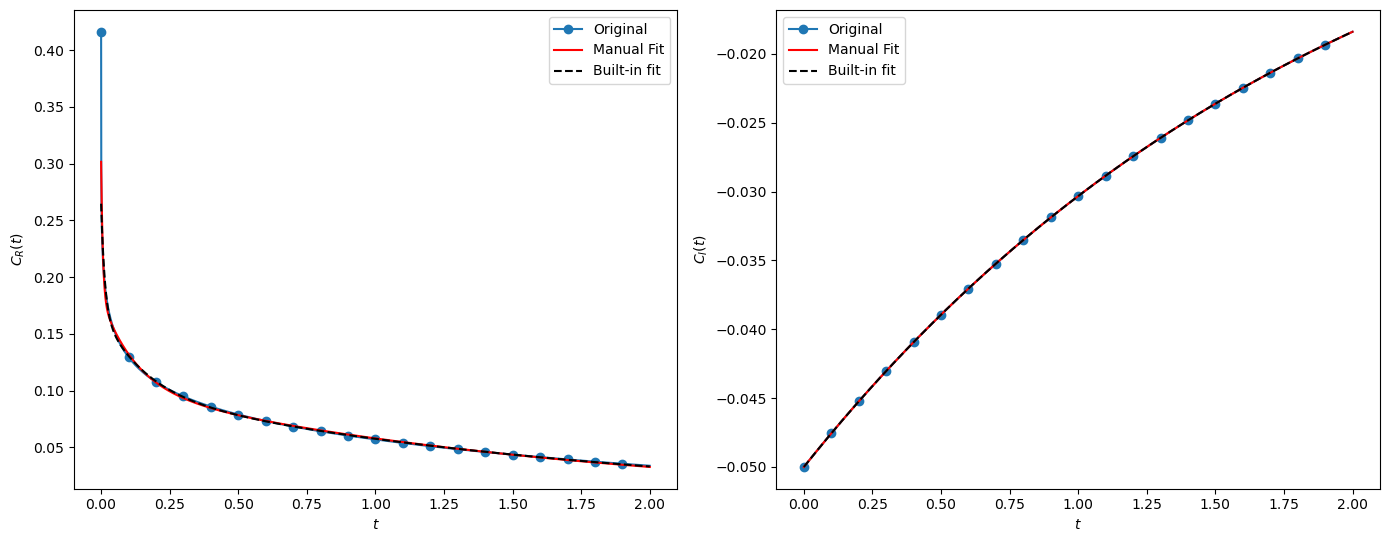

In [42]:
# Create a single figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the real part on the first subplot (ax1)
ax1.plot(tlist2, corrRana, label="Original", marker="o", markevery=500)
ax1.plot(tlist2, fit_func(tlist2, *poptR[-1]), color="r", label="Manual Fit")
ax1.plot(tlist2, np.real(envfit.correlation_function(tlist2)), "k--",
         label="Built-in fit")
ax1.set_ylabel(r"$C_{R}(t)$")
ax1.set_xlabel(r"$t$")
ax1.legend()

# Plot the imaginary part on the second subplot (ax2)
ax2.plot(tlist2, corrIana, label="Original", marker="o", markevery=500)
ax2.plot(tlist2, fit_func(tlist2, *poptI[-1]), color="r", label="Manual Fit")
ax2.plot(tlist2, np.imag(envfit.correlation_function(tlist2)), "k--",
         label="Built-in fit")
ax2.set_ylabel(r"$C_{I}(t)$")
ax2.set_xlabel(r"$t$")
ax2.legend()

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [43]:
options = {**default_options}

with timer("RHS construction time"):
    HEOMFit_2 = HEOMSolver(Hsys, (envfit, Q), NC, options=options)

with timer("ODE solver time"):
    resultFit_2 = HEOMFit_2.run(rho0, tlist)

RHS construction time: 0.023316144943237305
 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.57s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.57s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.57s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.57s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.57s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.57s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.57s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.57s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.58s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.58s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.58s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.58s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.58s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.58s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.59s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.59s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.59s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.59s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.59s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.59s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.59s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.60s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.60s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.60s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.60s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.60s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.60s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.60s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.61s / Remaining 00:00:00:00

 Total run time:   1.61s
ODE solver time: 1.6062426567077637


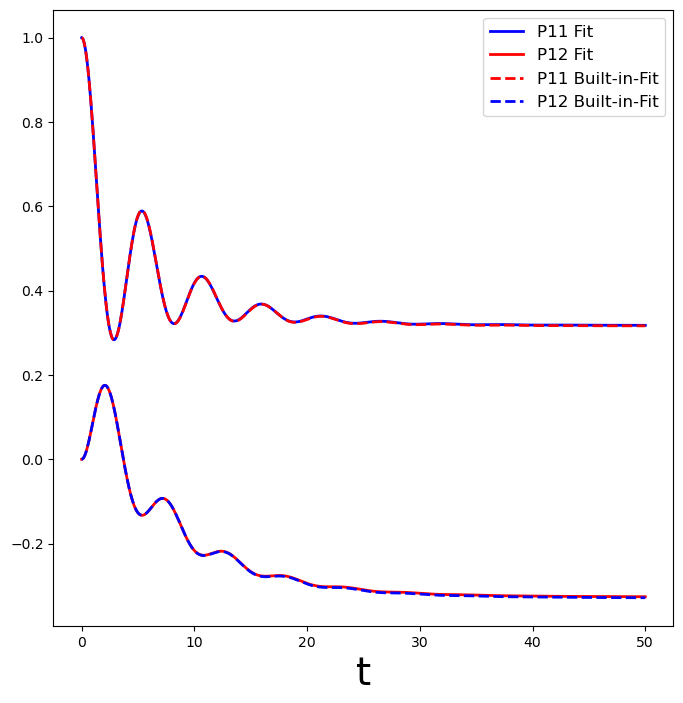

In [44]:
plot_result_expectations(
    [
        (resultFit, P11p, "b", "P11 Fit"),
        (resultFit, P12p, "r", "P12 Fit"),
        (resultFit_2, P11p, "r--", "P11 Built-in-Fit"),
        (resultFit_2, P12p, "b--", "P12 Built-in-Fit"),
    ]
);

## A reaction coordinate approach

Here we construct a reaction coordinate inspired model to capture the
steady-state behavior, and compare to the HEOM prediction. This result is
more accurate for narrow spectral densities.  We will use the population and
coherence from this cell in our final plot below.

In [45]:
dot_energy, dot_state = Hsys.eigenstates()
deltaE = dot_energy[1] - dot_energy[0]

gamma2 = deltaE / (2 * np.pi * gamma)
wa = 2 * np.pi * gamma2 * gamma  # reaction coordinate frequency
g = np.sqrt(np.pi * wa * lam / 2.0)  # reaction coordinate coupling
# reaction coordinate coupling factor over 2 because of diff in J(w)
# (it is 2 lam now):
g = np.sqrt(np.pi * wa * lam / 4.0)  #

NRC = 10

Hsys_exp = tensor(qeye(NRC), Hsys)
Q_exp = tensor(qeye(NRC), Q)
a = tensor(destroy(NRC), qeye(2))

H0 = wa * a.dag() * a + Hsys_exp
# interaction
H1 = g * (a.dag() + a) * Q_exp

H = H0 + H1

energies, states = H.eigenstates()
rhoss = 0 * states[0] * states[0].dag()
for kk, energ in enumerate(energies):
    rhoss += states[kk] * states[kk].dag() * np.exp(-beta * energies[kk])

rhoss = rhoss / rhoss.norm()


class ReactionCoordinateResult:
    def __init__(self, states, times):
        self.states = states
        self.times = times


resultRC = ReactionCoordinateResult([rhoss] * len(tlist), tlist)

P12RC = tensor(qeye(NRC), basis(2, 0) * basis(2, 1).dag())
P11RC = tensor(qeye(NRC), basis(2, 0) * basis(2, 0).dag())

## Let's plot all our results

Finally, let's plot all of our different results to see how they shape up against each other.

In [46]:
rcParams = {
    "axes.titlesize": 25,
    "axes.labelsize": 30,
    "xtick.labelsize": 28,
    "ytick.labelsize": 28,
    "legend.fontsize": 28,
    "axes.grid": False,
    "savefig.bbox": "tight",
    "lines.markersize": 5,
    "font.family": "STIXgeneral",
    "mathtext.fontset": "stix",
    "font.serif": "STIX",
    "text.usetex": False,
}

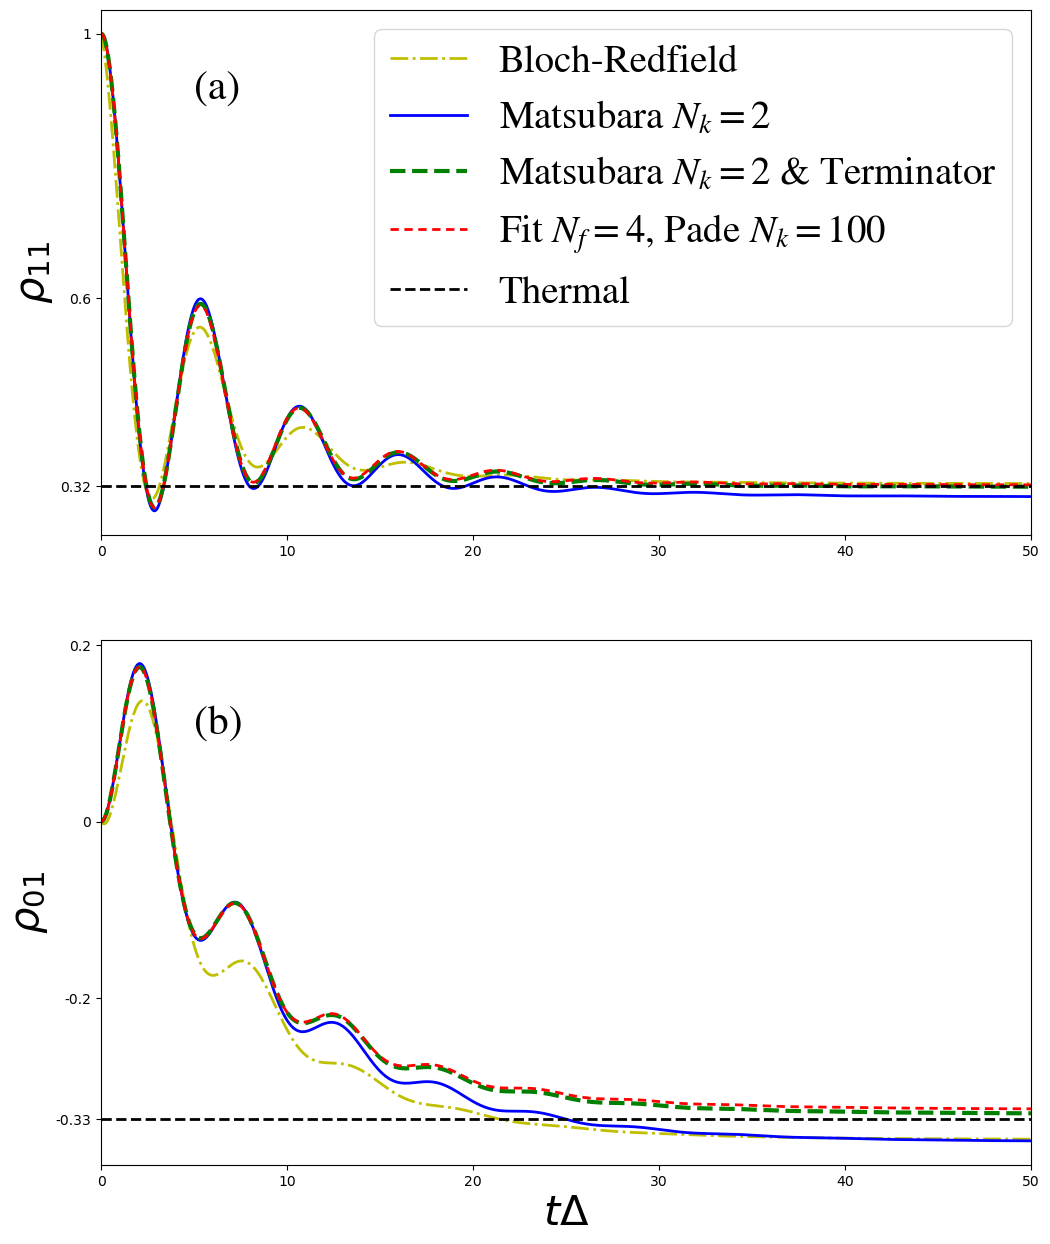

In [47]:
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(12, 15))

with plt.rc_context(rcParams):

    plt.sca(axes[0])
    plt.yticks([expect(P11RC, resultRC.states[0]), 0.6, 1.0], [0.32, 0.6, 1])
    plot_result_expectations(
        [
            (resultBR, P11p, "y-.", "Bloch-Redfield"),
            (resultMats, P11p, "b", "Matsubara $N_k=2$"),
            (
                resultMatsT,
                P11p,
                "g--",
                "Matsubara $N_k=2$ & Terminator",
                {"linewidth": 3},
            ),
            (
                resultFit,
                P11p,
                "r",
                r"Fit $N_f = 4$, Pade $N_k=100$",
                {"dashes": [3, 2]},
            ),
            (
                resultRC,
                P11RC,
                "--",
                "Thermal",
                {"linewidth": 2, "color": "black"},
            ),
        ],
        axes=axes[0],
    )
    axes[0].set_ylabel(r"$\rho_{11}$", fontsize=30)
    axes[0].legend(loc=0)
    axes[0].text(5, 0.9, "(a)", fontsize=30)
    axes[0].set_xlim(0, 50)

    plt.sca(axes[1])
    plt.yticks(
        [np.real(expect(P12RC, resultRC.states[0])), -0.2, 0.0, 0.2],
        [-0.33, -0.2, 0, 0.2],
    )
    plot_result_expectations(
        [
            (resultBR, P12p, "y-.", "Bloch-Redfield"),
            (resultMats, P12p, "b", "Matsubara $N_k=2$"),
            (
                resultMatsT,
                P12p,
                "g--",
                "Matsubara $N_k=2$ & Terminator",
                {"linewidth": 3},
            ),
            (
                resultFit,
                P12p,
                "r",
                r"Fit $N_f = 4$, Pade $N_k=100$",
                {"dashes": [3, 2]},
            ),
            (
                resultRC,
                P12RC,
                "--",
                "Thermal",
                {"linewidth": 2, "color": "black"},
            ),
        ],
        axes=axes[1],
    )
    axes[1].text(5, 0.1, "(b)", fontsize=30)
    axes[1].set_xlabel(r"$t \Delta$", fontsize=30)
    axes[1].set_ylabel(r"$\rho_{01}$", fontsize=30)
    axes[1].set_xlim(0, 50)

And that's the end of a detailed first dive into modeling bosonic environments with the HEOM.

## About

In [48]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


## Testing

This section can include some tests to verify that the expected outputs are generated within the notebook. We put this section at the end of the notebook, so it's not interfering with the user experience. Please, define the tests using assert, so that the cell execution fails if a wrong output is generated.

In [49]:
# Check P11p
assert np.allclose(
    expect(P11p, resultMatsT.states),
    expect(P11p, resultPade.states),
    rtol=1e-2,
)
assert np.allclose(
    expect(P11p, resultMatsT.states),
    expect(P11p, resultFit.states),
    rtol=1e-2,
)

# Check P12p
assert np.allclose(
    expect(P12p, resultMatsT.states),
    expect(P12p, resultPade.states),
    rtol=1e-2,
)
assert np.allclose(
    expect(P12p, resultMatsT.states),
    expect(P12p, resultFit.states),
    rtol=1e-1,
)